In [76]:
import numpy as np
import scipy.special as sp
import matplotlib.pyplot as plt
import pandas as pd

In [77]:
import sys
if "../src/" not in sys.path:
    sys.path.insert(0,"../src/")
from pbcpy.grid import DirectGrid, ReciprocalGrid
from pbcpy.field import DirectField, ReciprocalField
from pbcpy.functionals import *

%matplotlib inline
%load_ext autoreload
%autoreload 2
#

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
from pbcpy.local_functionals_utils import ThomasFermiEnergy, ThomasFermiPotential
from pbcpy.local_functionals_utils import vonWeizsackerEnergy, vonWeizsackerPotential

In [79]:
from pbcpy.formats.qepp import PP
from pbcpy.formats.xsf import XSF

In [80]:
from pbcpy.local_functionals_utils import x_TF_y_vW 
from pbcpy.nonlocal_functionals_utils import LindhardFunction, MGP_kernel, WT_kernel

In [81]:
from pbcpy.semilocal_xc import PBE, LDA, XC, KEDF

In [82]:
from pbcpy.local_pseudopotential import NuclearElectron

In [83]:
from pbcpy.hartree import HartreeFunctional

# Read Kinetic potenitals and real space electron densities from files 

In [84]:
for i in range(1,2):
    print(i)
    density = PP('../../Densities2/Al_'+str(i)+'_0_fde_0rho.pp').read()
    kin_pot = PP('../../Potentials2/Al_'+str(i)+'_0_vt_rhotot_alph.pp').read()
    density=density.field
    kin_pot =kin_pot.field/2.0

1


# Calculating the TF potential and vW potential

## This is the real space electron density

In [85]:
dens_real_space= density

## Calculate the TF potential  with the real space electron density

In [86]:
ThomasFermi = Functional(name='TF',energydensity=ThomasFermiEnergy(dens_real_space),
                         potential=ThomasFermiPotential(dens_real_space))

## Calculate the vW potential with the real space elecreon density

In [87]:
vonWeizsacker = Functional(name='vW',energydensity=vonWeizsackerEnergy(dens_real_space),
                           potential=vonWeizsackerPotential(dens_real_space,Sigma=0.26))

## Just plot the (TF/vW) potantials for fun  

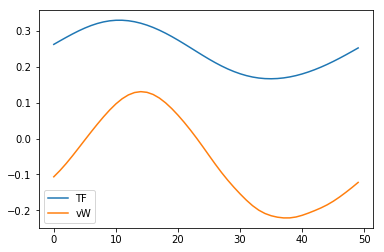

In [88]:
plt.plot(ThomasFermi.potential[:,10,10],label='TF')
plt.plot(vonWeizsacker.potential[:,10,10],label ='vW')
plt.legend()
plt.show()

## Evaluation of the Non-local Kinetic potential  

In [89]:
potential_NL= kin_pot - ThomasFermi.potential - vonWeizsacker.potential

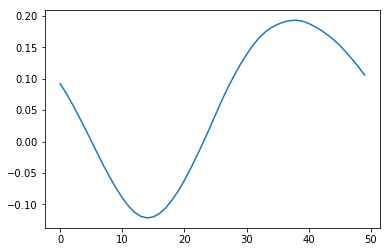

In [90]:
plt.plot(potential_NL[:,10,10])
plt.show()

## Define the so called "kernel" for given electron density and nonlocal potential

### NEED TO BE OPTIMIZED

In [91]:
def Kernel_1(Rho,Pot,kernel):
    Rho_16 = Rho**(1.0/6.0)
    Rho_56 = Rho**(5.0/6.0)
    ker1_r=pot*Rho_16
    ker2_g=Rho_56.fft()
    kernel= ker1.fft()/ker2
    return Kernel

In [92]:
def Kernel_2(Rho,Pot,kernel):
    Rho_16 = Rho**(1.0/6.0)
    ker1_r=pot*Rho_16
    kernel= ker1.fft()
    return Kernel

## The way to get the g space realated values

### The square of g  

In [93]:
gg=density.grid.get_reciprocal().gg

### the g

In [94]:
g=gg**0.5

### The avarange of elelctron density

In [95]:
rho0=density.integral() / density.grid.volume
print(rho0)

0.0136249002655


### The Fermi vector

In [74]:
tKF = (2.0*(3.0*np.pi**2.0*rho0)**(1.0/3.0))

### the $\eta$

In [75]:
eta = g/tKF